In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('../../data/data-2324-no-ver.csv')
print(df.head(1))

   Unnamed: 0  incident_id report_id  date_coded  \
0           0          203        17  2024-02-12   

                                                 url  \
0  https://twitter.com/DouglasLucas/status/171631...   

                                                file screenshot date_posted  \
0  Screenshot 2024-02-12 at 12.47.24 PM.png (http...        NaN  2023-10-23   

  format transcript  ...                               text_around_deepfake  \
0  image        NaN  ...  AI and the end of photographic truth? Deceptiv...   

            harm_evidence communication_goal      core_frame       hero  \
0  political_interference          education  human_interest  Joe Biden   

  villain                      plot                                    moral  \
0   Putin  Putin and Biden hugging   U.S. and Russian leaders can get along    

        domain    year  
0  twitter.com  2023.0  

[1 rows x 60 columns]


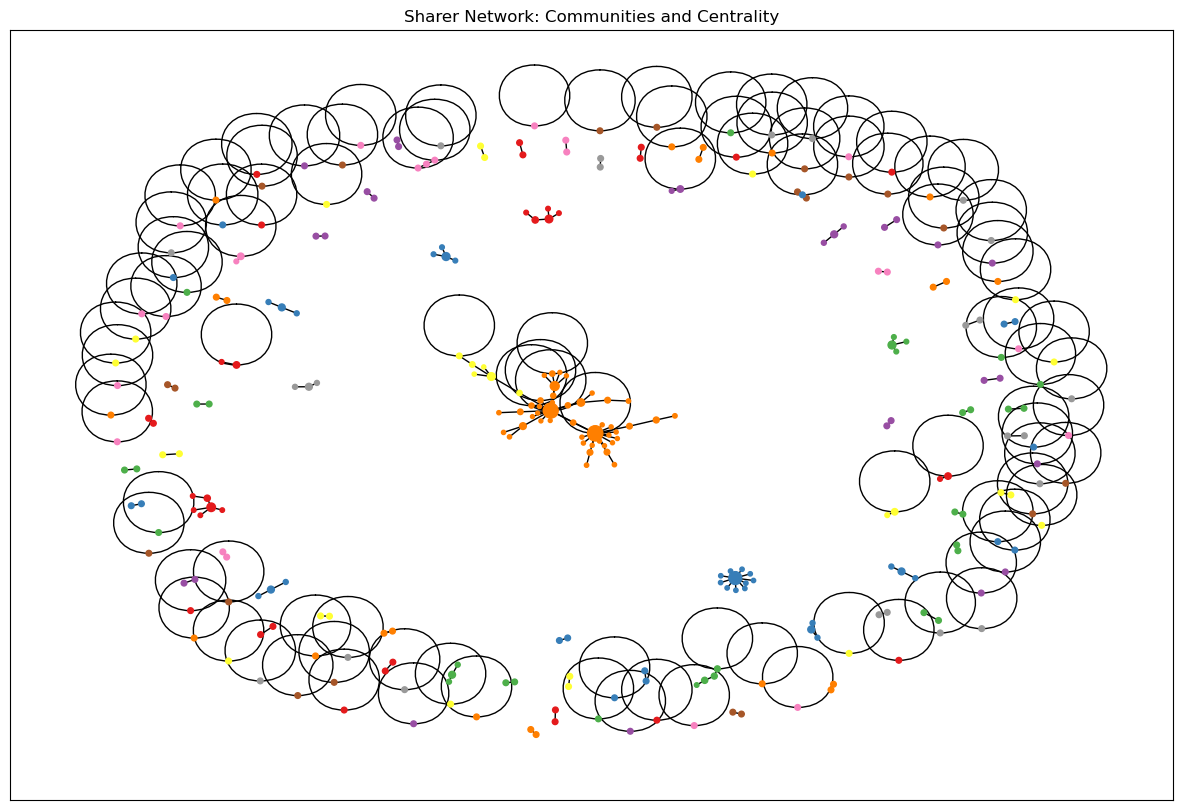

Top Spreaders: [('Donald Trump', 0.024272551306289507), ('Other', 0.02314444826776333), ('Brivael', 0.01719880811940527), ('Unknown', 0.00827798586696065), ('FakeAI.io', 0.00757676539769573), ('Human Events Daily', 0.006423220830696524), ('Hany Farid ', 0.006423220830696524), ('Na', 0.006173508452559571), ('Eliot Higgins', 0.00598126397200342), ('Trump_History45', 0.00564301807140747)]


In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import community as community_louvain  # install via pip install python-louvain

# Create sharer network
G = nx.Graph()

# Add edges between original source and sharers
for _, row in df.iterrows():
    source = row['original_source_name']
    sharer = row['sharer_name']
    if pd.notna(source) and pd.notna(sharer):
        G.add_edge(source, sharer)

# Community detection (Louvain algorithm)
partition = community_louvain.best_partition(G)

# Assign community as node attribute
nx.set_node_attributes(G, partition, 'community')

# Centrality (PageRank)
pagerank = nx.pagerank(G)

# Add PageRank to node attributes
nx.set_node_attributes(G, pagerank, 'pagerank')

# Draw graph
plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G, seed=42)
cmap = plt.cm.Set1
colors = [partition.get(node) for node in G.nodes()]
nx.draw_networkx(G, pos, node_color=colors, node_size=[v * 5000 for v in pagerank.values()], with_labels=False, cmap=cmap)
plt.title('Sharer Network: Communities and Centrality')
plt.show()

# Top spreaders
top_spreaders = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top Spreaders:", top_spreaders)


In [4]:
# Basic stats
print(f"Number of Nodes (Sharers + Sources): {G.number_of_nodes()}")
print(f"Number of Edges (Connections): {G.number_of_edges()}")
print(f"Average Degree: {sum(dict(G.degree()).values())/G.number_of_nodes():.2f}")
print(f"Density of the Network: {nx.density(G):.4f}")
print(f"Number of Connected Components: {nx.number_connected_components(G)}")

# Size of largest connected component
largest_cc = max(nx.connected_components(G), key=len)
print(f"Size of Largest Connected Component: {len(largest_cc)}")


Number of Nodes (Sharers + Sources): 299
Number of Edges (Connections): 250
Average Degree: 1.67
Density of the Network: 0.0056
Number of Connected Components: 154
Size of Largest Connected Component: 51


Top Sharers by Degree Centrality: [('Other', 0.06375838926174497), ('Donald Trump', 0.060402684563758385), ('Brivael', 0.03355704697986577), ('Unknown', 0.020134228187919462), ('FakeAI.io', 0.013422818791946308), ('Trump_History45', 0.013422818791946308), ('Na', 0.013422818791946308), ('No Context French', 0.010067114093959731), ('CypherTux', 0.010067114093959731), ('Eliot Higgins', 0.010067114093959731)]


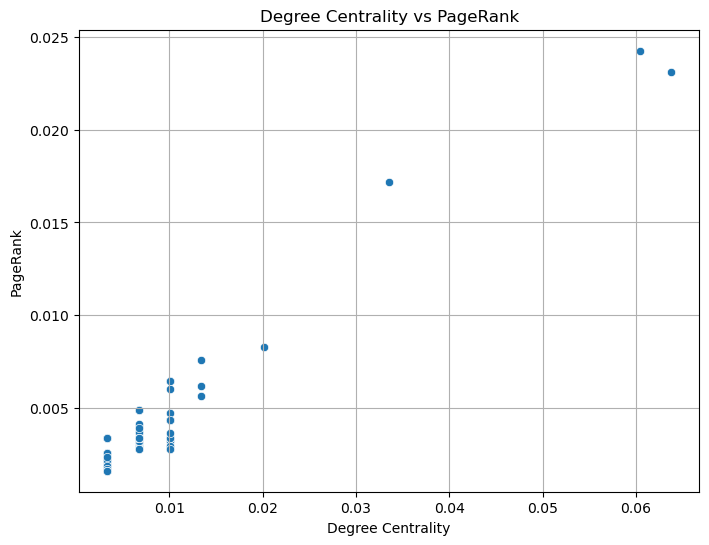

In [5]:
degree_centrality = nx.degree_centrality(G)

# Top 10 by degree
top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top Sharers by Degree Centrality:", top_degree)


centrality_df = pd.DataFrame({
    'node': list(degree_centrality.keys()),
    'degree_centrality': list(degree_centrality.values()),
    'pagerank': [pagerank.get(node, 0) for node in degree_centrality.keys()],
    'community': [partition.get(node, -1) for node in degree_centrality.keys()]
})

# Plot Degree vs PageRank
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.scatterplot(data=centrality_df, x='degree_centrality', y='pagerank')
plt.title('Degree Centrality vs PageRank')
plt.xlabel('Degree Centrality')
plt.ylabel('PageRank')
plt.grid(True)
plt.show()


In [6]:
# Group nodes by community
community_members = {}
for node, comm in partition.items():
    if comm not in community_members:
        community_members[comm] = []
    community_members[comm].append(node)

# Top 5 communities by size
largest_communities = sorted(community_members.items(), key=lambda x: len(x[1]), reverse=True)[:5]

for idx, (comm, members) in enumerate(largest_communities, 1):
    print(f"\nCommunity {idx} (size={len(members)}):")
    print(", ".join(members[:10]) + ('...' if len(members) > 10 else ''))  # print top 10 members



Community 1 (size=25):
Unknown, Lindsay P Gorman, Trump_History45, Benjamin Strick , Mark Kaye (Shaggy), CGTN America, @andreagail_k, Other, Golden Advice, @PlanetOfMemes...

Community 2 (size=20):
Cyncratic, @TraficBerbat, @Sassafrass_84, @Sassafrass_84 , Brain Hirsh, Brian Hirsh , Donald Trump, @akafacehots, Rusty Sutton , Dare Obasanjo...

Community 3 (size=11):
Brivael, Min Choi, Lightway, Brian Potra, Barsee, Asim Rehman, MalikShabaaz, Kenny Le, Leonardo Dias, Economic Times...

Community 4 (size=6):
FakeAI.io, heythatsmydrink, o2slo2.0, michelle_pearl_knows , cblase2, Leroy Sickler 

Community 5 (size=6):
Na, Ann Stein , Brick Suit (Blake Marnell), Ginny M, Creative Automation, GinnyM


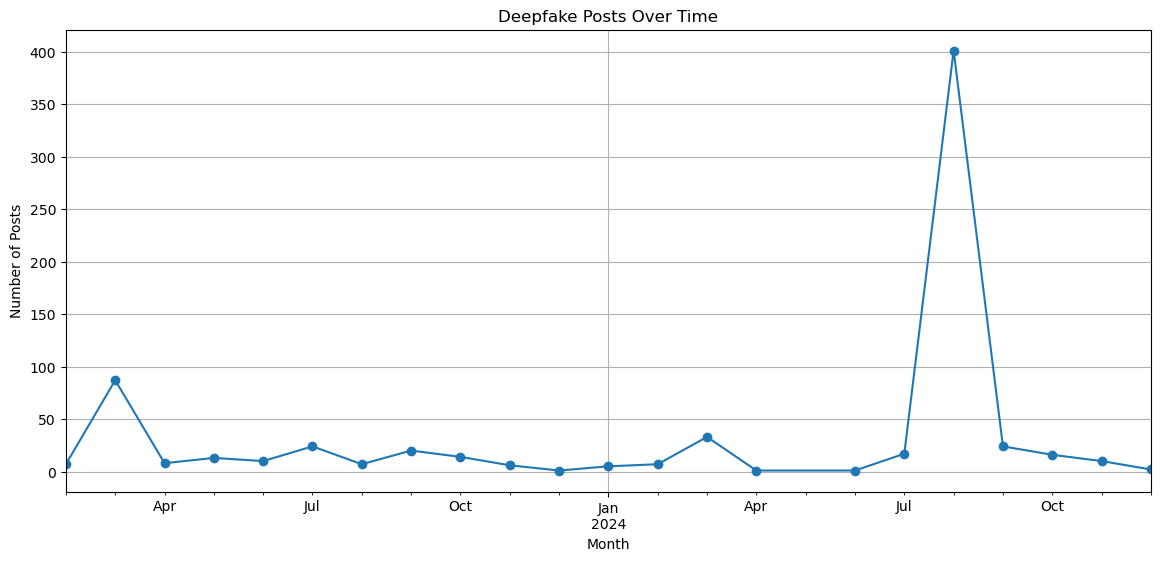

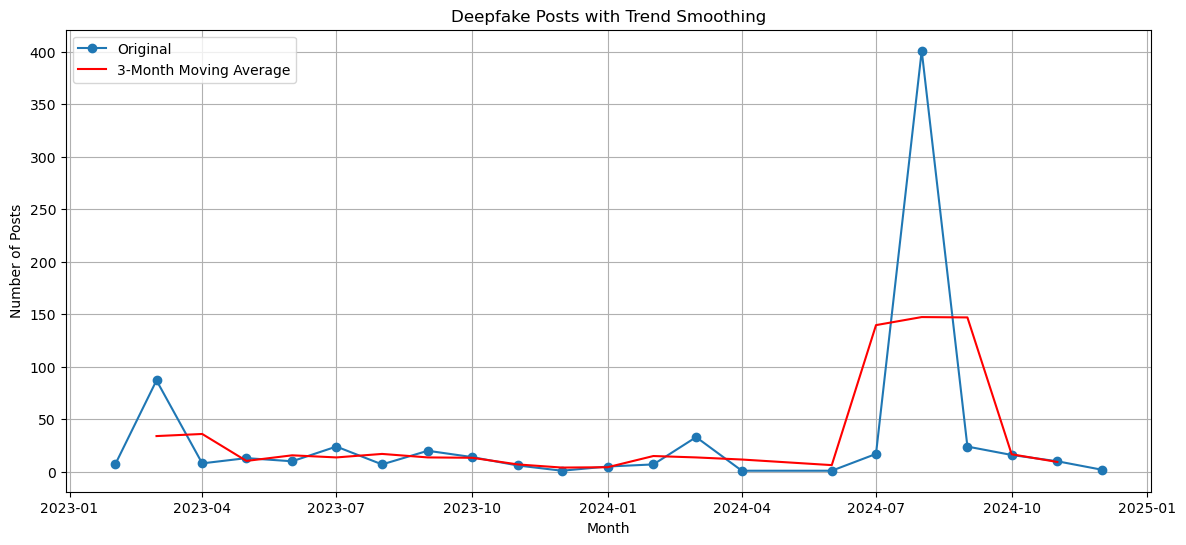

In [8]:
import seaborn as sns


# Ensure datetime format
df['date_posted'] = pd.to_datetime(df['date_posted'], errors='coerce')

# Posts per month
time_series = df.groupby(df['date_posted'].dt.to_period('M')).size()

# Plot time series
time_series.plot(figsize=(14, 6), marker='o')
plt.title('Deepfake Posts Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Posts')
plt.grid()
plt.show()

# Moving average smoothing instead
ts = time_series.to_timestamp()
ts_rolling = ts.rolling(window=3, center=True).mean()

plt.figure(figsize=(14,6))
plt.plot(ts, label='Original', marker='o')
plt.plot(ts_rolling, label='3-Month Moving Average', color='red')
plt.title('Deepfake Posts with Trend Smoothing')
plt.xlabel('Month')
plt.ylabel('Number of Posts')
plt.legend()
plt.grid()
plt.show()


In [9]:
import plotly.graph_objects as go

# Clean country columns
df['original_source_country'] = df['original_source_country'].fillna('Unknown')
df['sharer_country'] = df['sharer_country'].fillna('Unknown')

# Group flows
flows = df.groupby(['original_source_country', 'sharer_country']).size().reset_index(name='count')

# Prepare Sankey diagram data
sources = flows['original_source_country'].tolist()
targets = flows['sharer_country'].tolist()
values = flows['count'].tolist()

# Unique labels
labels = list(set(sources + targets))
label_to_index = {label: i for i, label in enumerate(labels)}

# Map labels to indices
source_indices = [label_to_index[src] for src in sources]
target_indices = [label_to_index[tgt] for tgt in targets]

# Create Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(pad=15, thickness=20, line=dict(color="black", width=0.5),
              label=labels),
    link=dict(source=source_indices, target=target_indices, value=values)
)])

fig.update_layout(title_text="Cross-Country Deepfake Dissemination", font_size=10)
fig.show()


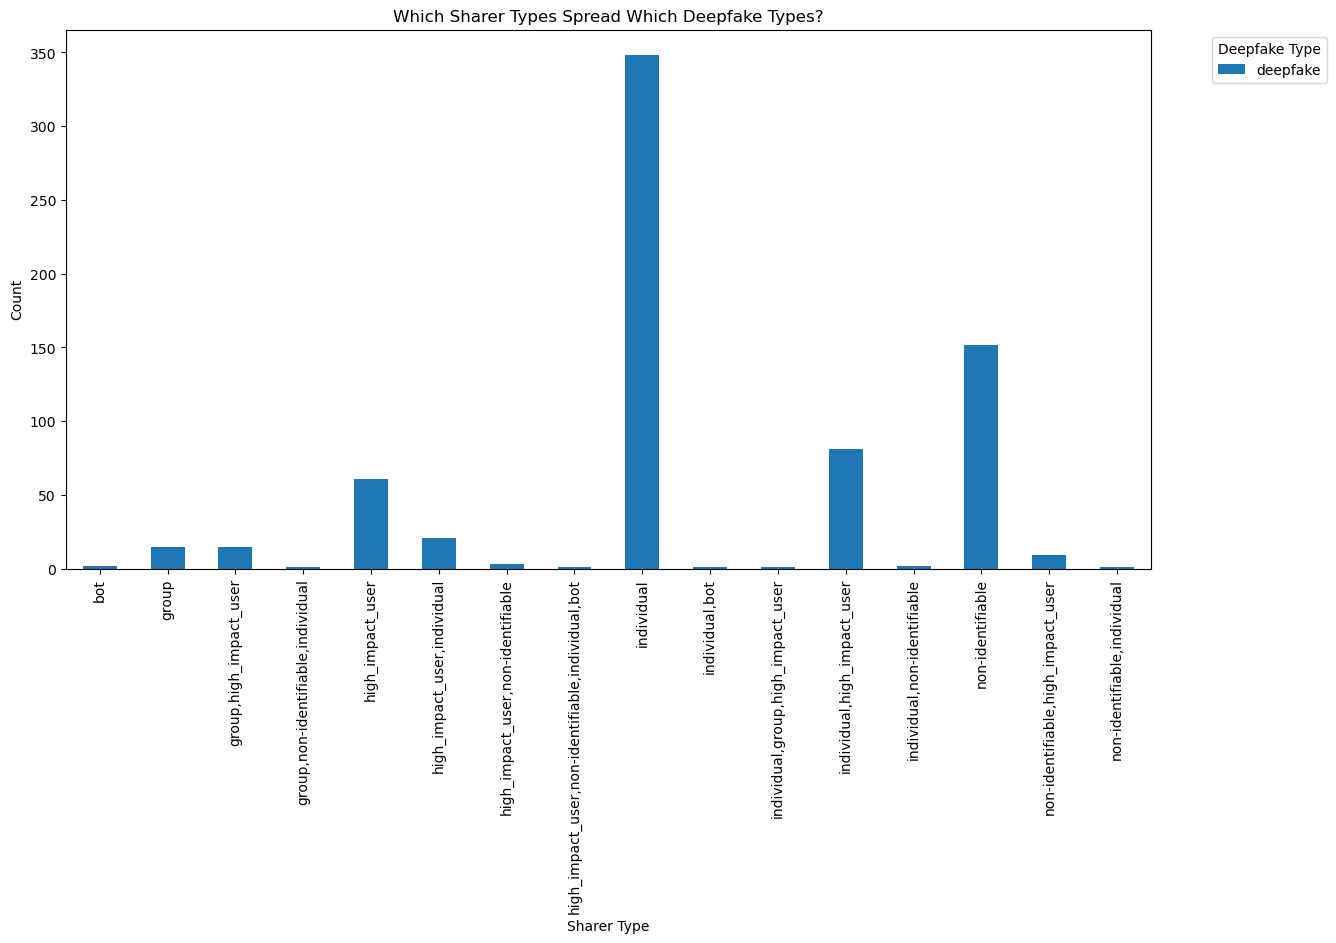

In [10]:
# Pivot table: sharer_type vs type of deepfake
pivot_table = pd.crosstab(df['sharer_type'], df['type'])

pivot_table.plot(kind='bar', stacked=True, figsize=(14, 7))
plt.title('Which Sharer Types Spread Which Deepfake Types?')
plt.xlabel('Sharer Type')
plt.ylabel('Count')
plt.legend(title='Deepfake Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
